<a href="https://colab.research.google.com/github/tanhata/Manhattan/blob/main/Harlem_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install -y python-rtree;
!pip install geopandas sodapy shapely rtree cenpy;

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  javascript-common libjs-jquery libjs-underscore libspatialindex-c4v5
  libspatialindex-dev libspatialindex4v5 python-pkg-resources
Suggested packages:
  apache2 | lighttpd | httpd python-setuptools
The following NEW packages will be installed:
  javascript-common libjs-jquery libjs-underscore libspatialindex-c4v5
  libspatialindex-dev libspatialindex4v5 python-pkg-resources python-rtree
0 upgraded, 8 newly installed, 0 to remove and 34 not upgraded.
Need to get 959 kB of archives.
After this operation, 5,146 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 javascript-common all 11 [6,066 B]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libjs-jqu

In [2]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import geopandas as gpd
import matplotlib.pyplot as plt
from sodapy import Socrata
import cenpy
from scipy.stats import pearsonr
from shapely import wkt
from shapely.geometry import shape
from shapely.ops import nearest_points
import urllib.request, json 
from shapely.geometry import Point, Polygon

In [3]:
#use socrata personal key
client = Socrata("data.cityofnewyork.us", 'S8JvsbGoDguEN16oahuM1PMae')

In [4]:
#pull hbldg footprint data, json url code, limit to 2 mil
#results = client.get("hmxn-fxqm", limit=2000) #building footprints
#rezoning = client.get("fd95-5ihz", limit=2000)
#demographics = client.get("tncb-agv4", limit=2000)
housing_stock = client.get("hg8x-zxpr", limit=2000)
# Convert to pandas DataFrame
#results_df = pd.DataFrame.from_records(results)
#rezoning_df = pd.DataFrame.from_records(rezoning)
#demographics_df = pd.DataFrame.from_records(demographics)
housing_df = pd.DataFrame.from_records(housing_stock)

In [6]:
#pull prop value data,json url code, simplified boro to only manhattan akak 1, then limit to 1 mil entries
valuation = client.get("yjxr-fw8i", where='BORO = 1',limit=100000000)

#pull hbldg footprint data, json url code, limit to 2 mil
bldgs = client.get("hmxn-fxqm", limit=2000)

KeyboardInterrupt: ignored

In [ ]:
manhattan_prop_df = pd.DataFrame.from_records(valuation)
footprints_df = pd.DataFrame.from_records(bldgs)

In [ ]:
manhattan_prop_df.head()

,bble,boro,block,lot,owner,bldgcl,taxclass,ltfront,ltdepth,stories,fullval,avland,avtot,exland,extot,excd1,staddr,bldfront,blddepth,avland2,avtot2,exland2,extot2,period,year,valtype,zip,exmptcl,easement,borough,latitude,longitude,community_board,council_district,census_tract,bin,nta,geocoded_column,ext,excd2
0,1000163859,1,16,3859,"CHEN, QI TOM",R4,2,0,0,31,354180,3310,159381,3310,159381,6800,1 RIVER TERRACE,0,0,3310,148953,3310,148953,FINAL,2018/19,AC-TR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000730028,1,73,28,NYC DSBS,V1,4,183,52,NaN,3515000,1581750,1581750,1581750,1581750,2191,MARGINAL STREET,0,0,1080594,1080594,1080594,1080594,FINAL,2018/19,AC-TR,10038,X1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000730029,1,73,29,NYC DSBS,Y7,4,90,500,1,8215000,2812050,3696750,2812050,3696750,2191,MARGINAL STREET,90,258,2812050,3487680,2812050,3487680,FINAL,2018/19,AC-TR,10038,X1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1000297504,1,29,7504,NaN,R0,2,36,73,7,0,0,0,0,0,NaN,54 STANTON ST EXTENSION,36,73,NaN,NaN,NaN,NaN,FINAL,2018/19,AC-TR,10004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1000360012,1,36,12,NYC DSBS,Y7,4,534,604,NaN,26246000,9180000,11810700,9180000,11810700,2191,PIER 9,0,604,9180000,11142540,9180000,11142540,FINAL,2018/19,AC-TR,NaN,X1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
footprints_df.head()

,bin,cnstrct_yr,the_geom,lstmoddate,lststatype,doitt_id,heightroof,feat_code,groundelev,shape_area,shape_len,base_bbl,mpluto_bbl,geomsource
0,3394646,2009,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",2017-08-22T00:00:00.000Z,Constructed,1212853,21.60850812,2100,18,854.66243317866,125.0797955584,3044520815,3044520815,Photogramm
1,4548330,1930,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",2017-08-17T00:00:00.000Z,Constructed,1226227,10.36,5110,122,217.59424346169,60.22585821856,4030640041,4030640041,Photogramm
2,4460479,1960,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",2017-08-22T00:00:00.000Z,Constructed,581946,29.81157033,2100,10,946.42747637737,123.14194057237,4139430001,4139430001,Photogramm
3,3355684,1920,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",2017-08-17T00:00:00.000Z,Constructed,858061,11.2,5110,32,248.67816852809,63.94081721089,3049720006,3049720006,Photogramm
4,3131737,1915,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",2017-08-22T00:00:00.000Z,Constructed,568078,24.98,2100,44,1163.227668698,165.60876340496,3055100055,3055100055,Photogramm


In [ ]:
#only 2018/2019 data + making BBL column
manhattan_prop_df = manhattan_prop_df[manhattan_prop_df['year'] == '2018/19']
manhattan_prop_df['bbl'] = manhattan_prop_df['boro'] + manhattan_prop_df['block'] + manhattan_prop_df['lot']

In [ ]:
manhattan_prop_df = manhattan_prop_df.dropna(subset=['latitude'])
print(manhattan_prop_df.shape)
manhattan_prop_df.head(2)

(160877, 41)


,bble,boro,block,lot,owner,bldgcl,taxclass,ltfront,ltdepth,stories,fullval,avland,avtot,exland,extot,excd1,staddr,bldfront,blddepth,avland2,avtot2,exland2,extot2,period,year,valtype,zip,exmptcl,easement,borough,latitude,longitude,community_board,council_district,census_tract,bin,nta,geocoded_column,ext,excd2,bbl
16,1009287504,1,928,7504,NaN,R0,2,24,100,19,0,0,0,0,0,NaN,300 EAST 23 STREET,0,0,NaN,NaN,NaN,NaN,FINAL,2018/19,AC-TR,10010,NaN,NaN,MANHATTAN,40.73773,-73.980554,106,2,64,1088559,Gramercy,"{'type': 'Point', 'coordinates': [-73.980554, ...",NaN,NaN,19287504
17,1010607502,1,1060,7502,NaN,R0,2,150,200,16,0,0,0,0,0,NaN,425 WEST 50 STREET,0,0,NaN,NaN,NaN,NaN,FINAL,2018/19,AC-TR,10019,NaN,NaN,MANHATTAN,40.763878,-73.989853,104,3,133,1026676,Clinton,"{'type': 'Point', 'coordinates': [-73.989853, ...",NaN,NaN,110607502


In [ ]:
#renaming geocoded column to geom, then converting the existing data to a str that shapely can read (google), that is what coords=; for wktloads
manhattan_prop_df.rename(columns={'geocoded_column': 'geom'}, inplace=True)
coords = [str(Point(entry['coordinates'])) for entry in manhattan_prop_df['geom']]
manhattan_prop_df['geom'] = coords
manhattan_prop_df['geom'] = manhattan_prop_df['geom'].apply(wkt.loads)

In [ ]:
coords2 = [str(Polygon(entry['coordinates'][0][0])) for entry in footprints_df['the_geom']]
footprints_df['the_geom'] = coords2
print(footprints_df.shape)
footprints_df['the_geom'] = footprints_df['the_geom'].apply(wkt.loads)
footprints_df.head(2)

(2000, 14)


,bin,cnstrct_yr,the_geom,lstmoddate,lststatype,doitt_id,heightroof,feat_code,groundelev,shape_area,shape_len,base_bbl,mpluto_bbl,geomsource
0,3394646,2009,POLYGON ((-73.87129515296562 40.65717370043455...,2017-08-22T00:00:00.000Z,Constructed,1212853,21.60850812,2100,18,854.66243317866,125.0797955584,3044520815,3044520815,Photogramm
1,4548330,1930,POLYGON ((-73.87670970144625 40.71425234541623...,2017-08-17T00:00:00.000Z,Constructed,1226227,10.36,5110,122,217.59424346169,60.22585821856,4030640041,4030640041,Photogramm


In [ ]:
from shapely.geometry import Point, Polygon 

#Polygon(footprints_df['the_geom'][0]['coordinates'][0][0])

In [ ]:
footprints_df= gpd.GeoDataFrame(footprints_df, geometry ='the_geom')
manhattan_prop_df = gpd.GeoDataFrame(footprints_df, geometry='geom')
footprints_df = footprints_df.set_crs(epsg=3857)
manhattan_prop_df = manhattan_prop_df.set_crs(epsg=3857)

In [ ]:
combined = footprints_df.merge(manhattan_prop_df, left_on='mpluto_bbl',
                       right_on='bble')

In [ ]:
classes = ['1', '2', '2A', '2B', '1D', '2C', '1B']
combined = combined[combined['taxclass'].isin(classes)]

In [ ]:
print(combined.shape)
combined.head(1)

(34390, 56)


,bin_x,cnstrct_yr,the_geom,lstmoddate,lststatype,doitt_id,heightroof,feat_code,groundelev,shape_area,shape_len,base_bbl,mpluto_bbl,geomsource,name,bble,boro,block,lot,owner,bldgcl,taxclass,ltfront,ltdepth,stories,fullval,avland,avtot,exland,extot,staddr,zip,bldfront,blddepth,avland2,avtot2,period,year,valtype,borough,latitude,longitude,community_board,council_district,census_tract,bin_y,nta,geom,excd1,exland2,extot2,ext,exmptcl,easement,excd2,bbl
1,1039988,1931,POLYGON ((-73.96425191767109 40.75860443341254...,2017-08-22T00:00:00.000Z,Constructed,66240,167.21446831,2100,52,4652.20272097352,302.5855511998,1013490035,1013490035,Photogramm,NaN,1013490035,1,1349,35,340 EAST 57TH ST ASSO,D6,2,116,71,16,12329000,1530000,5548050,0,0,340 EAST 57 STREET,10022,102,50,1530000,5301900,FINAL,2018/19,AC-TR,MANHATTAN,40.758759,-73.964008,106,5,108,1039988,Turtle Bay-East Midtown,POINT (-73.96400800000001 40.758759),NaN,NaN,NaN,NaN,NaN,NaN,NaN,1134935


In [ ]:
poi = client.get("c49g-hsw9", limit=25500)
poi_df = pd.DataFrame.from_records(poi)

In [ ]:
poi_df['the_geom'] = poi_df['the_geom'].apply(lambda x: shape(x))

In [ ]:
poi_df = gpd.GeoDataFrame(poi_df, geometry='the_geom')
poi_df = poi_df.set_crs(epsg=3857)

In [ ]:
places = ['bike' 'green' 'park' 'recreation' 'health']
bike_df = poi_df[(poi_df['facility_t']=='6') & 
                    (poi_df['name'].str.lower().str.contains('|'.join(places)))]

In [ ]:
bike_df

,saftype,the_geom,complexid,segmentid,sos,placeid,faci_dom,bin,borough,created,modified,facility_t,source,b7_sc,pri_add,name
2,N,POINT (-73.95802 40.75849),0,138896,1,1026908,8,0,1,2015-10-20T00:00:00.000Z,2020-03-16T00:00:00.000Z,6,DoITT,19792015,0,KOCH BR PEDESTRIAN AND BIKE PATH
3,N,POINT (-73.95062 40.75530),0,139388,1,1026909,8,0,4,2015-10-20T00:00:00.000Z,2020-03-16T00:00:00.000Z,6,DoITT,49734017,0,KOCH BR PEDESTRIAN AND BIKE
32,N,POINT (-73.92688 40.84643),0,297515,2,1026966,8,0,2,2015-10-23T00:00:00.000Z,2017-07-28T00:00:00.000Z,6,DoITT,29820004,0,WASHINGTON BR PED AND BIKE
35,N,POINT (-73.93357 40.81958),0,295140,1,1026910,8,0,1,2015-10-21T00:00:00.000Z,2018-04-19T00:00:00.000Z,6,OTHER,19775004,0,145 ST BRIDGE PED AND BIKE
36,N,POINT (-73.93313 40.80739),0,241749,2,1026929,8,0,1,2015-10-23T00:00:00.000Z,2018-04-19T00:00:00.000Z,6,DoITT,19771002,0,3 AV BRIDGE PED AND BIKE
46,N,POINT (-73.93213 40.81948),0,262102,1,1026911,8,0,2,2015-10-21T00:00:00.000Z,NaN,6,OTHER,29830007,0,145 ST BRIDGE PED AND BIKE
51,N,POINT (-73.92800 40.80407),15,258838,1,1026971,8,0,2,2015-10-23T00:00:00.000Z,NaN,6,DoITT,21003003,0,WILLIS AVENUE BRIDGE BIKE
53,N,POINT (-73.94366 40.76247),0,258890,1,1026956,8,0,4,2015-10-23T00:00:00.000Z,NaN,6,DoITT,49736003,0,ROOSEVELT IS BR PED & BIKE
54,N,POINT (-73.93241 40.81412),0,240167,2,1026943,8,0,2,2015-10-23T00:00:00.000Z,2020-09-01T00:00:00.000Z,6,DoITT,29827007,0,MADISON AV BRDG PED & BIKE
55,N,POINT (-73.95280 40.73910),0,235753,2,1026951,8,0,3,2015-10-23T00:00:00.000Z,NaN,6,DoITT,39740004,0,PULASKI BRIDGE BIKE


In [ ]:
for i in range(len(poi_df)):
  if 'BIKE' in poi_df['name'][i]: 
    print(poi_df['name'][i])

KOCH BR PEDESTRIAN AND BIKE PATH
KOCH BR PEDESTRIAN AND BIKE
WASHINGTON BR PED AND BIKE
145 ST BRIDGE PED AND BIKE
3 AV BRIDGE PED AND BIKE
145 ST BRIDGE PED AND BIKE
WILLIS AVENUE BRIDGE BIKE
ROOSEVELT IS BR PED & BIKE
MADISON AV BRDG PED & BIKE
PULASKI BRIDGE BIKE
PULASKI BRIDGE BIKE
RFK BRIDGE PED AND BIKE
RFK BRIDGE PED AND BIKE
BAYONNE BR PED AND BIKE
BROOKLYN BRIDGE PED AND BIKE
UNIV HEIGHTS BR BIKE AND PED
UNIV HEIGHTS BR BIKE AND PED
MARINE PY-GIL HODGES BR BIKE
MARINE PY-GIL HODGES BR BIKE
WASHINGTON BR PED AND BIKE
RFK BR QUEENS PED AND BIKE PATH
WILLIAMSBURG BR BIKE AND PED
MADISON AV BRDG PED & BIKE
CROSS BAY VET MEM BRIDGE BIKE PATH
GW BRIDGE BIKE AND PEDESTRIAN
MANHATTAN BRIDGE BIKE PATH
ROOSEVELT IS BR PED & BIKE
RFK BRIDGE BRONX PED AND BIKE PATH
RFK BR BRONX PED AND BIKE PATH
3 AVENUE BRIDGE BIKE
RFK BR QUEENS PED AND BIKE PATH
WILLIAMSBURG BR BIKE AND PED
BROOKLYN BRDG PED AND BIKE
MANHATTAN BRIDGE BIKE
WILLIS AVENUE BRIDGE BIKE
FLSHNG MDW PK BOAT & BIKE RENTAL
BROOKL

In [ ]:
bike = bike_df.the_geom.unary_union

def near(point, pts):
    # find the nearest poi
    nearest = nearest_points(point, pts)[1]
    return point.distance(nearest)

combined['distance'] = combined.apply(lambda x: near(x.the_geom.centroid, bike), axis=1)

Text(0.5, 1.0, 'Property Value by Distance to Bike Paths')

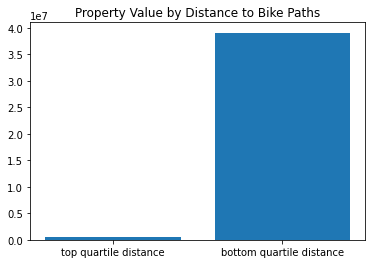

In [ ]:
combined['fullval'] = combined['fullval'].astype('int')
closer = combined[combined['fullval'] < combined['fullval'].quantile(.25)]['fullval'].mean()
further = combined[combined['fullval'] > combined['fullval'].quantile(.75)]['fullval'].mean()
plt.bar(['top quartile distance', 'bottom quartile distance'], [closer, further])
plt.title('Property Value by Distance to Bike Paths')
# Save to a PDF file
#plt.savefig('prop_val_bike.pdf')

In [ ]:
pearsonr(combined['distance'].loc[(combined['fullval'] > 200000) & (combined['fullval'] < 1000000)], 
         combined['fullval'].loc[(combined['fullval'] > 200000) & (combined['fullval'] < 1000000)])


(0.009461255351531936, 0.6103600880793767)

In [ ]:
closer

bin_x                    inf
doitt_id                 inf
feat_code                inf
base_bbl                 inf
mpluto_bbl               inf
bble                     inf
boro                     inf
block                    inf
lot                      inf
ltfront                  inf
ltdepth                  inf
fullval                  inf
avland                   inf
avtot                    inf
exland                   inf
extot                    inf
zip                      inf
bldfront                 inf
blddepth                 inf
community_board          inf
council_district         inf
census_tract             inf
easement                 NaN
bbl                      inf
distance            0.008254
dtype: float64

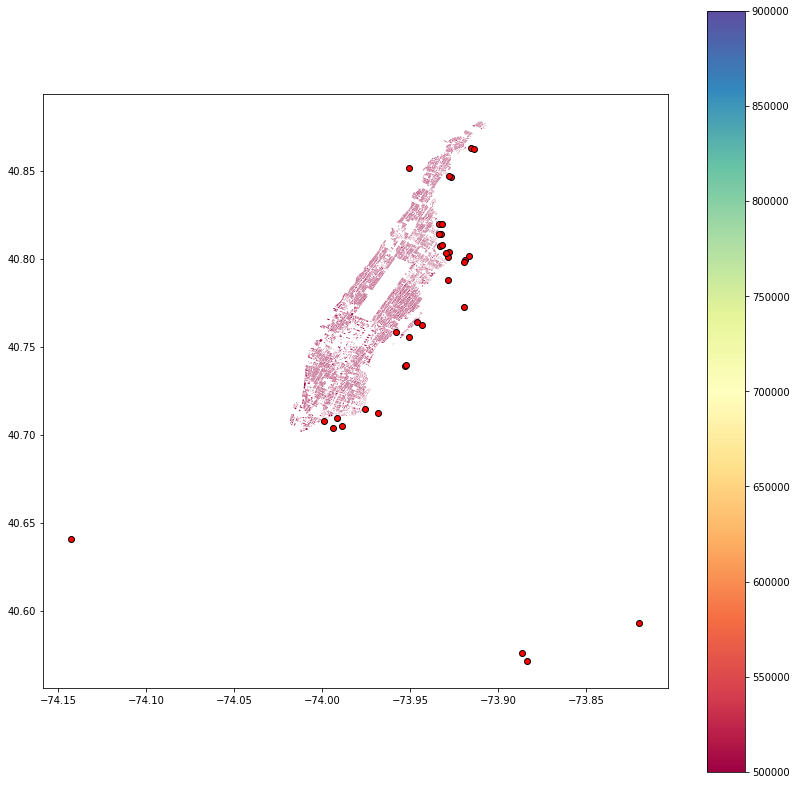

In [ ]:
ax = bike_df.plot(color='red', edgecolor="black", figsize=(14, 14))
combined.plot(column='distance', ax=ax,
              vmin=500000, vmax=900000, cmap='Spectral',
              legend=True, figsize=(14, 14)) #.loc[combined['BORO'] == '1']

In [5]:
housing_df.head()

,project_id,project_name,program_group,project_start_date,building_id,house_number,street_name,borough,postcode,bbl,community_board,council_district,census_tract,neighborhood_tabulation_area,latitude,longitude,latitude_internal,longitude_internal,reporting_construction_type,extended_affordability_status,prevailing_wage_status,extremely_low_income_units,very_low_income_units,low_income_units,moderate_income_units,middle_income_units,other_income_units,studio_units,_1_br_units,_2_br_units,_3_br_units,_4_br_units,_5_br_units,_6_br_units,unknown_br_units,counted_rental_units,counted_homeownership_units,all_counted_units,total_units,bin,project_completion_date,building_completion_date
0,68797,445 GERARD AVENUE,Multifamily Incentives Program,2020-12-31T00:00:00.000,991233,445,GERARD AVENUE,Bronx,10451,2023510012,BX-01,8,63,BX63,40.817398,-73.929872,40.81754,-73.930096,New Construction,No,Non Prevailing Wage,0,0,71,0,0,0,2,49,20,0,0,0,0,0,71,0,71,338,NaN,NaN,NaN
1,68866,MAXWELL DEVELOPMENT LP.YR15.FY21,Multifamily Finance Program,2020-12-31T00:00:00.000,41403,143,WEST 140 STREET,Manhattan,10030,1020090018,MN-10,9,230,MN03,40.817879,-73.939944,40.81794,-73.939572,Preservation,Yes,Non Prevailing Wage,27,22,5,0,0,1,0,14,27,7,7,0,0,0,55,0,55,55,1060064,NaN,NaN
2,68866,MAXWELL DEVELOPMENT LP.YR15.FY21,Multifamily Finance Program,2020-12-31T00:00:00.000,41405,151,WEST 140 STREET,Manhattan,10030,1020090012,MN-10,9,230,MN03,40.817947,-73.940113,40.81811,-73.939969,Preservation,Yes,Non Prevailing Wage,4,48,2,0,0,1,0,21,20,7,7,0,0,0,55,0,55,55,1060063,NaN,NaN
3,68866,MAXWELL DEVELOPMENT LP.YR15.FY21,Multifamily Finance Program,2020-12-31T00:00:00.000,41431,227,WEST 140 STREET,Manhattan,10030,1020260014,MN-10,9,230,MN03,40.818904,-73.942389,40.81937,-73.942952,Preservation,Yes,Non Prevailing Wage,3,16,0,0,0,1,0,3,13,4,0,0,0,0,20,0,20,20,1060404,NaN,NaN
4,68866,MAXWELL DEVELOPMENT LP.YR15.FY21,Multifamily Finance Program,2020-12-31T00:00:00.000,41436,233,WEST 140 STREET,Manhattan,10030,1020260009,MN-10,9,230,MN03,40.818953,-73.942508,40.81947,-73.943172,Preservation,Yes,Non Prevailing Wage,12,16,2,0,0,1,0,6,17,8,0,0,0,0,31,0,31,31,1060401,NaN,NaN


In [7]:
newconst = housing_df[housing_df['reporting_construction_type']=='New Construction']
newconst.head()

,project_id,project_name,program_group,project_start_date,building_id,house_number,street_name,borough,postcode,bbl,community_board,council_district,census_tract,neighborhood_tabulation_area,latitude,longitude,latitude_internal,longitude_internal,reporting_construction_type,extended_affordability_status,prevailing_wage_status,extremely_low_income_units,very_low_income_units,low_income_units,moderate_income_units,middle_income_units,other_income_units,studio_units,_1_br_units,_2_br_units,_3_br_units,_4_br_units,_5_br_units,_6_br_units,unknown_br_units,counted_rental_units,counted_homeownership_units,all_counted_units,total_units,bin,project_completion_date,building_completion_date
0,68797,445 GERARD AVENUE,Multifamily Incentives Program,2020-12-31T00:00:00.000,991233,445,GERARD AVENUE,Bronx,10451,2023510012,BX-01,8,63,BX63,40.817398,-73.929872,40.81754,-73.930096,New Construction,No,Non Prevailing Wage,0,0,71,0,0,0,2,49,20,0,0,0,0,0,71,0,71,338,NaN,NaN,NaN
9,69330,414 GERARD AVENUE,Multifamily Incentives Program,2020-12-31T00:00:00.000,993841,414,GERARD AVENUE,Bronx,10451,2023500001,BX-01,17,63,BX63,40.817096,-73.92997,40.81712,-73.929605,New Construction,No,Non Prevailing Wage,0,0,43,0,0,0,0,27,16,0,0,0,0,0,43,0,43,206,NaN,NaN,NaN
14,64886,ROCKAWAY VILLAGE PHASE 3,Multifamily Finance Program,2020-12-30T00:00:00.000,996947,1721,REDFERN AVENUE,Queens,11691,4155370053,QN-14,31,103202,QN15,40.606694,-73.753145,40.60639,-73.753153,New Construction,No,Non Prevailing Wage,89,88,176,0,0,1,42,102,163,47,0,0,0,0,354,0,354,354,NaN,NaN,NaN
27,63772,BRONX POINT A,Multifamily Finance Program,2020-12-29T00:00:00.000,975365,65,EAST 149 STREET,Bronx,10451,2023560002,BX-04,8,63,BX63,40.819422,-73.931333,40.82018,-73.931639,New Construction,No,Non Prevailing Wage,163,108,162,108,0,1,135,192,122,93,0,0,0,0,542,0,542,542,NaN,NaN,NaN
28,65499,29 WEST STREET,Multifamily Incentives Program,2020-12-29T00:00:00.000,996955,29,WEST STREET,Brooklyn,11222,NaN,BK-01,33,561,BK76,40.727124,-73.958826,NaN,NaN,New Construction,No,Non Prevailing Wage,0,0,215,0,0,0,53,54,108,0,0,0,0,0,215,0,215,216,NaN,NaN,NaN


In [83]:
MNnewconst = newconst[newconst['borough']=='Manhattan']
MNnewconst

,project_id,project_name,program_group,project_start_date,building_id,house_number,street_name,borough,postcode,bbl,community_board,council_district,census_tract,neighborhood_tabulation_area,latitude,longitude,latitude_internal,longitude_internal,reporting_construction_type,extended_affordability_status,prevailing_wage_status,extremely_low_income_units,very_low_income_units,low_income_units,moderate_income_units,middle_income_units,other_income_units,studio_units,_1_br_units,_2_br_units,_3_br_units,_4_br_units,_5_br_units,_6_br_units,unknown_br_units,counted_rental_units,counted_homeownership_units,all_counted_units,total_units,bin,project_completion_date,building_completion_date
32,69230,55 SUFFOLK STREET,Multifamily Incentives Program,2020-12-23T00:00:00.000,994593,55,SUFFOLK STREET,Manhattan,10002,1003460001,MN-03,1,1402,MN28,40.71695,-73.987158,40.71671,-73.987915,New Construction,No,Non Prevailing Wage,0,74,0,20,0,0,31,42,20,1,0,0,0,0,94,0,94,378,NaN,NaN,NaN
89,70480,CONFIDENTIAL,Homeowner Assistance Program,2020-11-25T00:00:00.000,NaN,----,----,Manhattan,NaN,NaN,MN-09,9,NaN,NaN,NaN,NaN,NaN,NaN,New Construction,No,Non Prevailing Wage,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,NaN,2020-11-25T00:00:00.000,2020-11-25T00:00:00.000
115,70474,CONFIDENTIAL,Homeowner Assistance Program,2020-11-10T00:00:00.000,NaN,----,----,Manhattan,NaN,NaN,MN-03,2,NaN,NaN,NaN,NaN,NaN,NaN,New Construction,No,Non Prevailing Wage,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,NaN,2020-11-10T00:00:00.000,2020-11-10T00:00:00.000
205,68859,241 WEST 28TH STREET,Multifamily Incentives Program,2020-10-15T00:00:00.000,991649,241,WEST 28 STREET,Manhattan,10001,1007780018,MN-05,3,95,MN17,40.747769,-73.99459,40.7483,-73.994951,New Construction,No,Non Prevailing Wage,0,0,96,0,0,0,39,49,7,1,0,0,0,0,96,0,96,480,NaN,NaN,NaN
218,70499,222 EAST 44TH STREET PHASE II,Multifamily Incentives Program,2020-10-01T00:00:00.000,13694,212,EAST 44 STREET,Manhattan,10017,1013170009,MN-06,4,88,MN19,40.751836,-73.972981,40.75131,-73.972689,New Construction,No,Non Prevailing Wage,0,0,0,16,0,0,8,7,1,0,0,0,0,0,16,0,16,429,NaN,NaN,NaN
244,70266,168 EAST 100TH STREET,Multifamily Incentives Program,2020-09-23T00:00:00.000,994198,168,EAST 100 STREET,Manhattan,10029,1016270042,MN-11,5,166,MN33,40.788144,-73.948406,40.78781,-73.94819,New Construction,No,Non Prevailing Wage,0,0,0,0,5,0,0,5,0,0,0,0,0,0,5,0,5,16,NaN,NaN,NaN
252,70308,CONFIDENTIAL,Homeowner Assistance Program,2020-09-18T00:00:00.000,NaN,----,----,Manhattan,NaN,NaN,MN-09,7,NaN,NaN,NaN,NaN,NaN,NaN,New Construction,No,Non Prevailing Wage,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,NaN,2020-09-18T00:00:00.000,2020-09-18T00:00:00.000
272,70241,42 EAST 132ND STREET,Multifamily Incentives Program,2020-08-25T00:00:00.000,993798,42,EAST 132 STREET,Manhattan,10037,1017560048,MN-11,9,206,MN03,40.809994,-73.937003,40.80976,-73.93709,New Construction,No,Non Prevailing Wage,0,0,3,0,0,0,0,2,1,0,0,0,0,0,3,0,3,12,NaN,2020-08-25T00:00:00.000,2020-08-25T00:00:00.000
275,67720,RISEBORO. 37 HILLSIDE AVENUE,Multifamily Finance Program,2020-08-20T00:00:00.000,986618,37,HILLSIDE AVENUE,Manhattan,10040,1021700118,MN-12,10,283,MN35,40.858508,-73.929532,40.85818,-73.929684,New Construction,No,Prevailing Wage,163,0,0,0,0,1,118,45,1,0,0,0,0,0,164,0,164,164,NaN,NaN,NaN
295,70539,NUL 125TH STREET,Multifamily Incentives Program,2020-07-30T00:00:00.000,869382,125,WEST 125 STREET,Manhattan,10027,1019107501,MN-10,9,222,MN11,40.808215,-73.946502,40.80866,-73.946841,New Construction,No,Non Prevailing Wage,18,68,84,0,0,1,21,86,64,0,0,0,0,0,171,0,171,171,NaN,NaN,NaN


In [84]:
#newconstuction targetted income levels
exlownc = MNnewconst[MNnewconst['extremely_low_income_units'] !='0']
vlownc=MNnewconst[MNnewconst['very_low_income_units'] !='0']
lownc= MNnewconst[MNnewconst['low_income_units'] !='0']['low_income_units']
modnw=MNnewconst[MNnewconst['moderate_income_units'] !='0']['moderate_income_units']
midnc=MNnewconst[MNnewconst['middle_income_units'] !='0']['middle_income_units']
onc=MNnewconst[MNnewconst['other_income_units'] !='0']['other_income_units']

In [74]:
#converting to percentages 
percentage_exl = (len(exlownc))/(len(MNnewconst))*100
percentage_vl = (len(vlownc))/(len(MNnewconst))*100
percentage_l = (len(lownc))/(len(MNnewconst))*100
percentage_mod = (len(modnw))/(len(MNnewconst))*100
percentage_mid = (len(midnc))/(len(MNnewconst))*100
percentage_other = (len(onc))/(len(MNnewconst))*100

100.0

In [85]:
MNnewconst['extremely_low_income_units'] = pd.to_numeric(MNnewconst['extremely_low_income_units'])
MNnewconst['very_low_income_units'] = pd.to_numeric(MNnewconst['very_low_income_units'])
MNnewconst['low_income_units'] = pd.to_numeric(MNnewconst['low_income_units'])
MNnewconst['moderate_income_units'] = pd.to_numeric(MNnewconst['moderate_income_units'])
MNnewconst['middle_income_units'] = pd.to_numeric(MNnewconst['middle_income_units'])
MNnewconst['very_low_income_units'] = pd.to_numeric(MNnewconst['very_low_income_units'])
MNnewconst['other_income_units'] = pd.to_numeric(MNnewconst['other_income_units'])

In [86]:
pd.unique(MNnewconst['program_group'])

array(['Multifamily Incentives Program', 'Homeowner Assistance Program',
       'Multifamily Finance Program', 'Small Homes Program'], dtype=object)

In [100]:
MN_newconstruction = MNnewconst[MNnewconst['program_group'] != 'Homeowner Assistance Program']

New Construction Units by Income Level


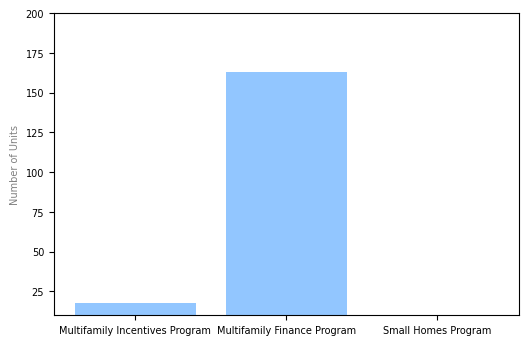

In [112]:
with plt.style.context('seaborn-pastel'):
  plt.rc('font', size = 7)

  plt.figure(dpi=100)
  print("New Construction Units by Income Level")
  plt.(MN_newconstruction.program_group,MN_newconstruction['extremely_low_income_units'])
  #plt.bar(MN_newconstruction.program_group,MN_newconstruction['very_low_income_units'], color = 'orange')
  #plt.scatter(MNnewconst.program_group,MNnewconst['low_income_units'], color = 'red')
  #plt.scatter(MNnewconst.program_group,MNnewconst['moderate_income_units'], color = 'blue')
  #plt.scatter(MNnewconst.program_group,MNnewconst['middle_income_units'], color = 'purple')
  #plt.scatter(MNnewconst.program_group,MNnewconst['other_income_units'], color = 'yellow')
  
  #plt.legend(['Extremely Low Income','Very Low Income','Low Income', 'Moderate Income', 'Middle Income', 'Other Income'], loc = "upper right", fontsize =  'x-small')
  #plt.xlabel('Number of New Construction Units', color = 'gray')
  plt.ylabel('Number of Units', color='gray')
  ax = plt.gca()
  ay = plt.gca()
  ay.set_ylim([10,200])
  plt.show()

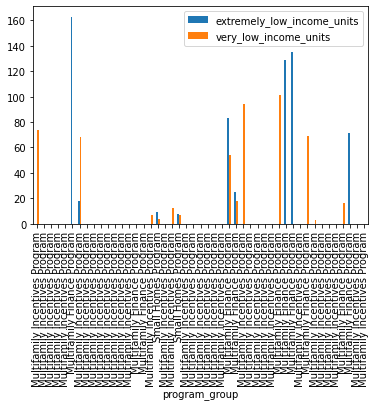

In [123]:
MN_newconstruction.plot(x="program_group", y=["extremely_low_income_units", "very_low_income_units"], kind="bar")